In [1]:
import pandas as pd

import torch
import numpy as np
import seaborn as sns
#from pylab import rcParams
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
#from textwrap import wrap
#from torch import nn, optim

In [2]:
import nltk
from nltk.corpus import stopwords
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, STOPWORDS
import spacy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_train = pd.read_csv('/content/drive/My Drive/datasets/Snowball/Training.csv')
df_test = pd.read_csv('/content/drive/My Drive/datasets/Snowball/Testing.csv')

In [5]:
df_train.head()

,Title,Abstract,Relevance
0,A Guide To The Project Management Body Of Know...,Its hard to imagine a time when A Guide to the...,0
1,Continuing Professional Development by Practit...,To prevent skilled professionals from being ph...,0
2,On a partnership between software industry and...,This paper discusses a role for industry in so...,0
3,Network Analysis of a Large Scale Open Source ...,One way to understand the structure of an open...,0
4,Design Science in Information Systems Research,Two paradigms characterize much of the researc...,0


In [6]:
df_test.head()

,Title,Abstract,Relevance
0,Structuring automotive product lines and featu...,Automotive systems are highly complex and cust...,0
1,Interventions for Software Security: Creating ...,Though some software development teams are hig...,0
2,Sustainability analysis and ease of learning i...,Context: Artifact-based requirements engineeri...,0
3,Light-Touch Interventions to Improve Software ...,Many software developers still have little int...,0
4,Academic and Industrial Software Testing Confe...,"Just as with any other profession, an efficien...",0


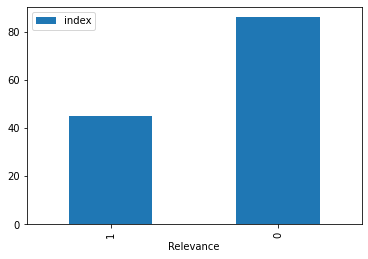

In [7]:
df_train["Relevance"].reset_index().groupby("Relevance").count().sort_values(by="index").plot(kind="bar") # training set is moderately unbalanced

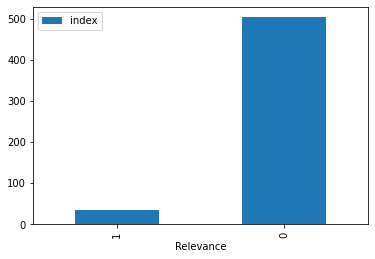

In [8]:
df_test["Relevance"].reset_index().groupby("Relevance").count().sort_values(by="index").plot(kind="bar") # test set is highly unbalanced

In [9]:
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [10]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [11]:
df_train.dtypes 

Title        object
Abstract     object
Relevance     int64
dtype: object

In [12]:
df_test.dtypes

Title        object
Abstract     object
Relevance     int64
dtype: object

In [13]:
df_train.isnull().sum() # nan values

Title        0
Abstract     3
Relevance    0
dtype: int64

In [14]:
df_test.isnull().sum() # nan values

Title        0
Abstract     6
Relevance    0
dtype: int64

In [15]:
df_train.shape, df_test.shape

((131, 3), (539, 3))

Removing nan values

In [16]:
df_train['Abstract'] = df_train['Abstract'].fillna(' ')

In [17]:
# Merge the Title and Abstract
df_train["Merged"] = df_train["Title"] + df_train["Abstract"]

In [18]:
df_train.head()

,Title,Abstract,Relevance,Merged
0,Collaborative Practice Research,Reports from a systems development research tr...,1,Collaborative Practice ResearchReports from a ...
1,Improving software security with static automa...,Software security can be improved by identifyi...,0,Improving software security with static automa...
2,"Worldviews, Research Methods, and their Relati...",Background - Validity threats should be consid...,0,"Worldviews, Research Methods, and their Relati..."
3,Research Collaborations between Academia and I...,The rapid and complex research and innovation ...,1,Research Collaborations between Academia and I...
4,Investigating Information Systems with Action ...,Action research is an established research met...,0,Investigating Information Systems with Action ...


In [19]:
df_train.isnull().sum()

Title        0
Abstract     0
Relevance    0
Merged       0
dtype: int64

In [20]:
df_test['Abstract'] = df_test['Abstract'].fillna(' ')
df_test["Merged"] = df_test["Title"] + df_test["Abstract"]

In [21]:
df_test.head()

,Title,Abstract,Relevance,Merged
0,Factors for Adopting and Implementing Accessib...,"Due to the increasing prevalence of laws, stan...",0,Factors for Adopting and Implementing Accessib...
1,MeSRAM - A method for assessing robustness of ...,Measurement programs in large software develop...,0,MeSRAM - A method for assessing robustness of ...
2,A Pearson Correlation Analysis of the Software...,Is well-known that software development proces...,0,A Pearson Correlation Analysis of the Software...
3,Light-Touch Interventions to Improve Software ...,Many software developers still have little int...,0,Light-Touch Interventions to Improve Software ...
4,Knowledge and technology transfer in sustainab...,This article aimed to propose and test a model...,0,Knowledge and technology transfer in sustainab...


In [22]:
df_test.isnull().sum()

Title        0
Abstract     0
Relevance    0
Merged       0
dtype: int64

In [23]:
X_train = df_train["Merged"]
y_train = df_train["Relevance"]

In [48]:
X_test = df_test["Merged"]
y_test = df_test["Relevance"]

In [25]:
X_train = X_train.astype(str)

In [49]:
X_test = X_test.astype(str) 

In [28]:
X_train

0      Collaborative Practice ResearchReports from a ...
1      Improving software security with static automa...
2      Worldviews, Research Methods, and their Relati...
3      Research Collaborations between Academia and I...
4      Investigating Information Systems with Action ...
                             ...                        
126    Get the Cogs in Synch: Time Horizon Aspects of...
127    Some researcher considerations when conducting...
128    Network Analysis of a Large Scale Open Source ...
129    Action Research as a Model for Industry-Academ...
130    An Assessment of the Scientific Merits of Acti...
Name: Merged, Length: 131, dtype: object

In [50]:
X_test

0      Factors for Adopting and Implementing Accessib...
1      MeSRAM - A method for assessing robustness of ...
2      A Pearson Correlation Analysis of the Software...
3      Light-Touch Interventions to Improve Software ...
4      Knowledge and technology transfer in sustainab...
                             ...                        
534    A case study of industry--academia communicati...
535    Lessons Learned from a Lean R\&D ProjectIn a p...
536    A general theory of software engineering: Bala...
537    Knowledge Management in University-Software In...
538    Assessing the effects of introducing a new sof...
Name: Merged, Length: 539, dtype: object

Text Preprocessing

In [29]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
#stopwords removal
def remove_stopwords(x):
    cap = x.split()
    cap = [w.lower() for w in cap]
    cap = [w for w in cap if w not in stopwords.words('english')]
    cap = [w for w in cap if w not in string.punctuation]
    return ' '.join(cap)


X_train = X_train.apply(remove_stopwords)

In [31]:
#tokenisation
def reduce_count(st):
    words = st.split()
    chars = ['-','.','&','=']
    for char in string.punctuation:
        words = [w for w in words if char not in w]
    words = [w for w in words if 5000 > tokenizer.word_counts[w] > 10]
    words.insert(0,'startseq')
    words.append('endseq')
    words = ' '.join(words)
    
    return words

for i in range(2):
    tokenizer = Tokenizer(oov_token='OOV')
    tokenizer.fit_on_texts(X_train)
    X_train = X_train.apply(reduce_count)
    tokenizer = Tokenizer(oov_token='OOV')
    tokenizer.fit_on_texts(X_train)

In [32]:
#remove punctuation
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

X_train = X_train.apply(lambda text: remove_punctuation(text))

In [33]:
#remove urls
import re
def removeurls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

X_train = X_train.apply(lambda text: removeurls(text))

X_train

0      startseq startseq collaborative practice syste...
1      startseq startseq software security analysis i...
2      startseq startseq research empirical software ...
3      startseq startseq research academia research i...
4      startseq startseq information systems action r...
                             ...                        
126    startseq startseq time collaboration many issu...
127    startseq startseq conducting empirical studies...
128    startseq startseq analysis large open way open...
129    startseq startseq action research model collab...
130    startseq startseq action science knowledge use...
Name: Merged, Length: 131, dtype: object

In [37]:
nlp = spacy.load('en_core_web_sm')
nlp.disable_pipes('ner', 'parser')
#lemmatisation
def space(review):
    doc = nlp(review)
    return " ".join([token.lemma_ for token in doc])

X_train = X_train.apply(space)
X_train

0      startseq startseq collaborative practice syste...
1      startseq startseq software security analysis i...
2      startseq startseq research empirical software ...
3      startseq startseq research academia research i...
4      startseq startseq information system action re...
                             ...                        
126    startseq startseq time collaboration many issu...
127    startseq startseq conduct empirical study must...
128    startseq startseq analysis large open way open...
129    startseq startseq action research model collab...
130    startseq startseq action science knowledge use...
Name: Merged, Length: 131, dtype: object

Tokenization

In [103]:
#Vectorisation and Tokenisation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
cv.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


CountVectorizer(stop_words='english',
                tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)

In [104]:
text_counts = cv.transform(X_train)

Repeat above processing on Test set


In [51]:
X_test = X_test.apply(remove_stopwords)

for i in range(2):
    tokenizer = Tokenizer(oov_token='OOV')
    tokenizer.fit_on_texts(X_test)
    X_test = X_test.apply(reduce_count)
    tokenizer = Tokenizer(oov_token='OOV')
    tokenizer.fit_on_texts(X_test)

X_test = X_test.apply(lambda text: remove_punctuation(text))

X_test = X_test.apply(lambda text: removeurls(text))

X_test = X_test.apply(space)


In [105]:
test_text_counts = cv.transform(X_test)

In [58]:
X_test

0      startseq startseq factor adopt implement softw...
1      startseq startseq method assess measurement pr...
2      startseq startseq analysis practice industry s...
3      startseq startseq intervention improve softwar...
4      startseq startseq knowledge technology transfe...
                             ...                        
534    startseq startseq case study communication joi...
535    startseq startseq lesson learn lean partnershi...
536    startseq startseq general theory software soci...
537    startseq startseq knowledge management industr...
538    startseq startseq assess effect new software d...
Name: Merged, Length: 539, dtype: object

ML models on Naive Bayes

In [64]:
from sklearn import metrics

In [106]:
from sklearn.naive_bayes import MultinomialNB
#Multinomial Naive Bayes
MNB = MultinomialNB()
MNB.fit(text_counts, y_train)

MultinomialNB()

In [107]:
MNB.score(text_counts, y_train)

0.8702290076335878

In [108]:
print(metrics.classification_report(MNB.predict(text_counts), y_train))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89        71
           1       0.98      0.73      0.84        60

    accuracy                           0.87       131
   macro avg       0.90      0.86      0.86       131
weighted avg       0.89      0.87      0.87       131



In [109]:
predicted = MNB.predict(test_text_counts)
accuracy_score = metrics.accuracy_score(predicted, y_test)

In [110]:
print(str('{:04.2f}'.format(accuracy_score*100))+'%')

68.09%


In [111]:
print(metrics.classification_report(predicted, y_test))

              precision    recall  f1-score   support

           0       0.68      0.97      0.80       351
           1       0.72      0.14      0.23       188

    accuracy                           0.68       539
   macro avg       0.70      0.55      0.52       539
weighted avg       0.69      0.68      0.60       539



In [88]:
#increasing n-gram range
cv1 = CountVectorizer(stop_words='english', ngram_range = (5,15), tokenizer = token.tokenize)
cv1.fit(X_train)
text_train = cv1.transform(X_train)
text_test = cv1.transform(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [89]:
MNB = MultinomialNB()
MNB.fit(text_train, y_train)

MultinomialNB()

In [90]:
MNB.score(text_train, y_train)

1.0

In [91]:
print(metrics.classification_report(MNB.predict(text_train), y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00        45

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131



In [92]:
accuracy_score = metrics.accuracy_score(MNB.predict(text_test), y_test)
print(str('{:04.2f}'.format(accuracy_score*100))+'%')

93.32%


In [93]:
print(metrics.classification_report(MNB.predict(text_test), y_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       535
           1       0.06      0.50      0.10         4

    accuracy                           0.93       539
   macro avg       0.53      0.72      0.53       539
weighted avg       0.99      0.93      0.96       539



In [94]:
#Defining and compiling the model -> we will use ComplementNB
from sklearn.naive_bayes import ComplementNB

#Fitting the model
CNB = ComplementNB()
CNB.fit(text_train, y_train)

#evaluating the model
#from sklearn import metrics
accuracy_score = metrics.accuracy_score(CNB.predict(text_test), y_test)

print(str('{:4.2f}'.format(accuracy_score*100))+'%')

93.14%


In [95]:
print(metrics.classification_report(CNB.predict(text_test), y_test))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       534
           1       0.06      0.40      0.10         5

    accuracy                           0.93       539
   macro avg       0.52      0.67      0.53       539
weighted avg       0.99      0.93      0.96       539



In [96]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(text_train.todense(), y_train)
accuracy_score_gnb = metrics.accuracy_score(GNB.predict(text_test.todense()), y_test)
print('accuracy_score_gnb = '+str('{:4.2f}'.format(accuracy_score_gnb*100))+'%')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


accuracy_score_gnb = 7.42%


In [97]:
print(metrics.classification_report(GNB.predict(text_test.todense()), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


              precision    recall  f1-score   support

           0       0.01      0.83      0.02         6
           1       0.97      0.07      0.12       533

    accuracy                           0.07       539
   macro avg       0.49      0.45      0.07       539
weighted avg       0.96      0.07      0.12       539



In [86]:
#Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()
BNB.fit(text_train, y_train)
accuracy_score_bnb = metrics.accuracy_score(BNB.predict(text_test), y_test)
print('BNB accuracy = ' + str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')

BNB accuracy = 93.32%


In [87]:
print(metrics.classification_report(BNB.predict(text_test), y_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97       539
           1       0.00      0.00      0.00         0

    accuracy                           0.93       539
   macro avg       0.50      0.47      0.48       539
weighted avg       1.00      0.93      0.97       539



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
#TFIDF Vectorisation to improve accuracy
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
train_text_2 = tfidf.transform(X_train)
test_text_2 = tfidf.transform(X_test)

#defining the model
#compilimg the model -> we are going to use already used models GNB, MNB, CNB, BNB
#fitting the model
MNB.fit(train_text_2, y_train)
accuracy_score_mnb = metrics.accuracy_score(MNB.predict(test_text_2), y_test)
print('accuracy_score_mnb = '+str('{:4.2f}'.format(accuracy_score_mnb*100))+'%')

BNB.fit(train_text_2, y_train)
accuracy_score_bnb = metrics.accuracy_score(BNB.predict(test_text_2), y_test)
print('accuracy_score_bnb = '+str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')

CNB.fit(train_text_2, y_train)
accuracy_score_cnb = metrics.accuracy_score(CNB.predict(test_text_2), y_test)
print('accuracy_score_cnb = '+str('{:4.2f}'.format(accuracy_score_cnb*100))+'%')

GNB.fit(train_text_2.todense(), y_train)
accuracy_score_gnb = metrics.accuracy_score(GNB.predict(test_text_2.todense()), y_test)
print('accuracy_score_gnb = '+str('{:4.2f}'.format(accuracy_score_gnb*100))+'%')

accuracy_score_mnb = 82.93%
accuracy_score_bnb = 78.85%
accuracy_score_cnb = 64.19%
accuracy_score_gnb = 47.87%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [113]:
print(metrics.classification_report(MNB.predict(test_text_2), y_test))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       453
           1       0.42      0.17      0.25        86

    accuracy                           0.83       539
   macro avg       0.64      0.56      0.57       539
weighted avg       0.79      0.83      0.80       539



In [115]:
MNB.score(train_text_2, y_train)

0.9007633587786259

The Best results were given by Multinomial NB with default parameters and TF-IDF Vectorization.
- Training Accuracy = 90.07%
- Testing Accuracy = 82.93%
- Precision, Recall, F1-score for each class is given in the last classification report.